# Multiple Linear Regression for Robot Calibration

In this lab, we will illustrate the use of multiple linear regression for calibrating robot control.  In addition to reviewing the concepts in multiple linear regression , you will see how to use multiple linear regression for time series data -- an important concept in dynamical systems such as robotics.

The data is from a three link robot:

<img src="https://rst.etit.tu-dortmund.de/storages/rst-etit/r/Media_Forschung/Robotik/Leichtbau/TUDORBild.png" height="200" width="200">


We will focus on predicting the current draw into one of the joints as a function of the robot motion.  Such models are essential in predicting the overall robot power consumption.  Several other models could also be used.

## Load and Visualize the Data
First, import the modules we will need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


The full MERIt dataset can be obtained from the [MERIt site](https://rst.etit.tu-dortmund.de/en/forschung/robotik/leichtbau/details-tudor/#c11560).  But, this dataset is large.  We include only two of the ten experiments.  Each experiments corresonds to 80 seconds of recorded motion.  We will use the following files:
* [exp1.csv](./exp1.csv) for training
* [exp2.csv](./exp2.csv) for test

If you are running this notebook on Google colab, you will need to run the following commands to load the files onto your local machine.  Otherwise, you can skip this step.

In [2]:
import os
from six.moves import urllib

for fn_dst in ['exp1.csv', 'exp2.csv']:
    fn_src = 'https://raw.githubusercontent.com/sdrangan/introml/master/unit03_mult_lin_reg/%s' % fn_dst

    if os.path.isfile(fn_dst):
        print('File %s is already downloaded' % fn_dst)
    else:
        print('Downloaded %s' % fn_dst)
        urllib.request.urlretrieve(fn_src, fn_dst)


File exp1.csv is already downloaded
File exp2.csv is already downloaded


Below, I have supplied the column headers in the `names` array.  Use the `pd.read_csv` command to load the training data in `exp1.csv`.  Use the `names` option to specify column names of the dataframe 

In [3]:
names =[
    't',                                  # Time (secs)
    'q1', 'q2', 'q3',                     # Joint angle   (rads)
    'dq1', 'dq2', 'dq3',                  # Joint velocity (rads/sec)
    'I1', 'I2', 'I3',                     # Motor current (A)
    'eps21', 'eps22', 'eps31', 'eps32',   # Strain gauge measurements ($\mu$m /m )
    'ddq1', 'ddq2', 'ddq3'                # Joint accelerations (rad/sec^2)
]
# TODO 
df = pd.read_csv('exp1.csv', names=names)


Print the first six lines of the pandas dataframe and manually check that they match the first rows of the csv file.

In [4]:
# TODO
df.head(n=6)


,t,q1,q2,q3,dq1,dq2,dq3,I1,I2,I3,eps21,eps22,eps31,eps32,ddq1,ddq2,ddq3
0,0.00,-0.000007,2.4958,-1.1345,-7.882100e-21,-4.940656e-321,3.913100e-29,-0.081623,-0.40812,-0.30609,-269.25,-113.20,3.5918,1.57860,-9.904900e-19,-6.210306e-319,4.917400e-27
1,0.01,-0.000007,2.4958,-1.1345,-2.258200e-21,-4.940656e-321,2.626200e-31,-0.037411,-0.37241,-0.26698,-270.91,-116.05,1.4585,-1.73980,4.248100e-19,-1.766878e-319,-1.381100e-27
2,0.02,-0.000007,2.4958,-1.1345,-6.469800e-22,-4.940656e-321,1.762500e-33,-0.066319,-0.40302,-0.31459,-269.25,-112.97,3.5918,0.86753,3.233800e-19,-4.990557e-320,-4.117300e-28
3,0.03,-0.000007,2.4958,-1.1345,-1.853600e-22,-4.940656e-321,1.182800e-35,-0.068020,-0.43703,-0.28398,-269.97,-114.39,1.6956,-0.08059,1.500500e-19,-1.394253e-320,-1.173100e-28
4,0.04,-0.000007,2.4958,-1.1345,-5.310600e-23,-4.940656e-321,-5.270900e-03,-0.052715,-0.40472,-0.30779,-269.97,-114.15,3.1177,0.86753,5.932400e-20,-3.581976e-321,-3.770800e-01
5,0.05,-0.000007,2.4958,-1.1345,-1.521500e-23,-4.940656e-321,3.252600e-04,-0.088425,-0.42342,-0.29589,-269.25,-114.15,2.4066,-0.08059,2.164600e-20,-1.141292e-321,2.930300e-01


From the dataframe `df`, extract the time indices into a vector `t` and extract `I2`, the current into the second joint.  Place the current in a vector `y` and plot `y` vs. `t`.   Label the axes with the units.

[-0.40812  -0.37241  -0.40302  ...  0.06802   0.011903  0.037411]
[0.000e+00 1.000e-02 2.000e-02 ... 7.997e+01 7.998e+01 7.999e+01]


Text(0.5, 0, 'time')

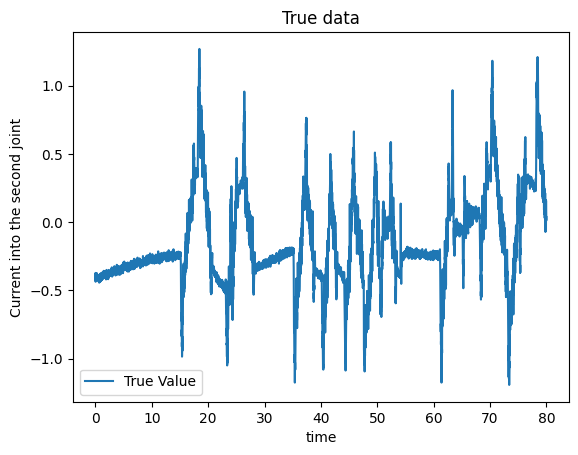

In [5]:
# TODO
y = df.iloc[:, 8].values # Select all rows and the 9th column.
print(y)
t = df.iloc[:, 0].values # Select all rows and 1st column.
print(t)
plt.plot(t, y, '-', label='True Value')
plt.legend()
plt.title("True data")
plt.ylabel("Current into the second joint")
plt.xlabel("time")


Use all the samples from the experiment 1 dataset to create the training data:
* `ytrain`:  A vector of all the samples from the `I2` column
* `Xtrain`:  A matrix of the data with the columns:  `['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']`

In [6]:
# TODO
ytrain = df.iloc[:, 8].values
print(ytrain)
Xtrain = df.iloc[:, [2,5,10,11,12,13,15]] # select all rows and 3rd, 6th, 11th, 13th, 14th, and 16th columns.
print(Xtrain)


[-0.40812  -0.37241  -0.40302  ...  0.06802   0.011903  0.037411]
          q2            dq2   eps21    eps22    eps31    eps32           ddq2
0     2.4958 -4.940656e-321 -269.25 -113.200   3.5918  1.57860 -6.210306e-319
1     2.4958 -4.940656e-321 -270.91 -116.050   1.4585 -1.73980 -1.766878e-319
2     2.4958 -4.940656e-321 -269.25 -112.970   3.5918  0.86753 -4.990557e-320
3     2.4958 -4.940656e-321 -269.97 -114.390   1.6956 -0.08059 -1.394253e-320
4     2.4958 -4.940656e-321 -269.97 -114.150   3.1177  0.86753 -3.581976e-321
...      ...            ...     ...      ...      ...      ...            ...
7995  1.9441   1.092700e+00 -110.44  -40.434  -2.3340  3.71190   3.884400e-01
7996  1.9550   1.081500e+00 -114.71  -41.619  -2.0969  1.10460  -6.908700e-01
7997  1.9659   1.095700e+00 -118.03  -41.856  -2.0969  3.71190   8.226400e-01
7998  1.9768   1.091300e+00 -133.20  -57.737 -12.5260 -5.76930  -8.205000e-02
7999  1.9877   1.089900e+00 -135.57  -56.078 -11.1040 -1.50280  -1.255900e-0

## Fit a Linear Model
Use the `sklearn.linear_model` module to create a `LinearRegression` object `regr`.

In [7]:
from sklearn import linear_model

# Create linear regression object
# TODO
regr = linear_model.LinearRegression()


Train the model on the training data.

In [8]:
# TODO
regr.fit(Xtrain, ytrain)


LinearRegression()

Using the trained model, compute, `ytrain_pred`, the predicted current.  Plot `ytrain_pred` vs. time `t`.  On the same plot, plot the actual current `ytrain` vs. time `t`.  Create a legend for the plot.

Text(0.5, 0, 'time')

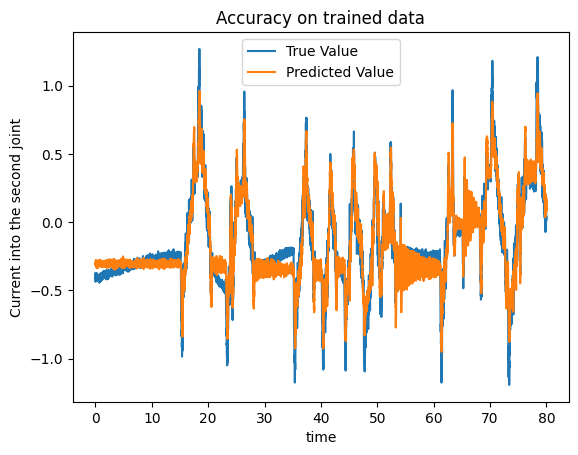

In [9]:
# TODO
ytrain_pred = regr.predict(Xtrain)
plt.plot(t, ytrain, '-', label='True Value')
plt.plot(t, ytrain_pred, '-', label='Predicted Value')
plt.legend()
plt.title("Accuracy on trained data")
plt.ylabel("Current into the second joint")
plt.xlabel("time")


Measure the normalized RSS given by `RSS / (n s^2_y).

In [10]:
# TODO
# Residual Sum of Squares. Also called Sum of Squared Residuals (SSR) and Sum of Squared Errors (SSE).
RSS_train = 0
MSE = 0
SY2 = 0
i = 0
ym = np.mean(ytrain)
while (i < len(ytrain)):
    MSE += (ytrain[i] - ytrain_pred[i])**2
    SY2 += (ytrain[i] - ym)**2
    i+=1

RSS_train = MSE / SY2
RSS_train


0.09583263861233182

## Measure the Fit on an Indepdent Dataset

Up to now, we have only tested the model on the same data on which it was trained.  In general, we need to test model on independent data not used in the training.  For this purpose, load the data in `exp2.csv`.  Compute the regression predicted values on this data and plot the predicted and actual values over time.

Text(0.5, 0, 'time')

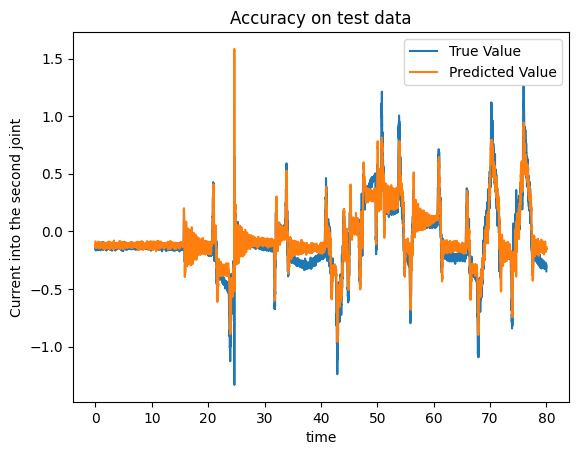

In [11]:
# TODO
test_df = pd.read_csv("exp2.csv", names=names)
test_t = test_df.iloc[:, 0].values
ytest = test_df.iloc[:, 8].values
Xtest = test_df.iloc[:, [2,5,10,11,12,13,15]] # select all rows and 3rd, 6th, 11th, 13th, 14th, and 16th columns.

ytest_pred = regr.predict(Xtest)
plt.plot(test_t, ytest, '-', label='True Value')
plt.plot(test_t, ytest_pred, '-', label='Predicted Value')
plt.legend()
plt.title("Accuracy on test data")
plt.ylabel("Current into the second joint")
plt.xlabel("time")


In [12]:
test_df.head()


,t,q1,q2,q3,dq1,dq2,dq3,I1,I2,I3,eps21,eps22,eps31,eps32,ddq1,ddq2,ddq3
0,0.00,-0.000007,1.9024,0.26063,-0.000364,4.940656e-321,0.012596,-0.096928,-0.15134,-0.017005,-130.83,-41.856,-6.3635,5.13410,-0.045712,6.210306e-319,1.582900
1,0.01,0.000013,1.9024,0.26073,0.000739,4.940656e-321,0.012095,-0.028908,-0.11903,-0.020406,-138.18,-51.100,-14.6590,-5.05820,0.125580,1.766878e-319,0.414660
2,0.02,-0.000007,1.9024,0.26086,-0.000580,4.940656e-321,0.011596,-0.059517,-0.13944,-0.047614,-139.36,-51.812,-14.6590,-5.29520,-0.130080,4.990557e-320,0.082286
3,0.03,0.000013,1.9024,0.26099,0.001409,4.940656e-321,0.013933,-0.079923,-0.15304,-0.023807,-135.57,-48.019,-11.3410,-0.79168,0.213010,1.394253e-320,0.190650
4,0.04,-0.000007,1.9024,0.26110,-0.001273,4.940656e-321,0.010793,-0.025507,-0.12924,-0.006802,-135.81,-49.204,-12.0520,-2.21390,-0.276490,3.581976e-321,-0.170400


Measure the normalized RSS on the test data.

In [13]:
# TODO
RSS_test = 0
MSE_test = 0
SY2_test = 0
j = 0
ym_test = np.mean(ytest)
while (j < len(ytest)):
    MSE_test += (ytest[j] - ytest_pred[j])**2
    SY2_test += (ytest[j] - ym_test)**2
    j+=1

RSS_test = MSE_test / SY2_test
RSS_test


0.12678048804762293